In [1]:
from typing import TypedDict

from generalist.agents.core import CapabilityPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task


class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: CapabilityPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str  

/Users/maksim.rostov/pdev/freestyling/agents/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


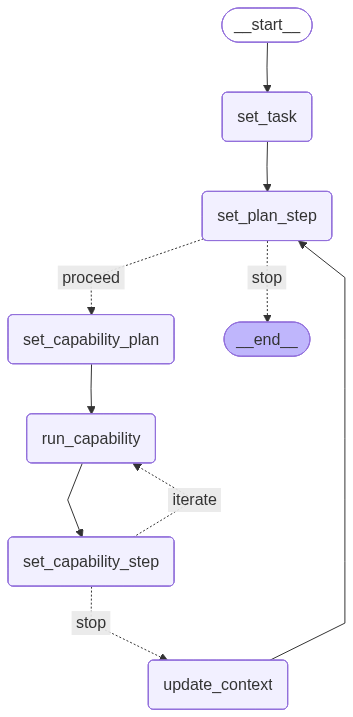

In [2]:
import json
from generalist.agents.core import AgentCapabilityDeepWebSearch, AgentCapabilityUnstructuredDataProcessor, AgentCapabilityCodeWritterExecutor, AgentCapabilityAudioProcessor
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


workflow = StateGraph(state_schema=ExecutionState)

def init_state(ask: str, resources: list[ContentResource] = list()) -> ExecutionState:
    # TODO: should I be using LLM to convert attachments/resources to acceptable format?
    # TODO: implement proper handling of attachments and resources 
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources,
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    resources = state["resources"]
    task_plan_response = create_plan(question_task, resources)

    # FIXME: delete this
    print(task_plan_response)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    return state

def set_plan_step(state: ExecutionState) -> ExecutionState: 
    """  
    Determine which state is being executed. 
    """
    if state["step"] is None: 
        state["step"] = 0 
    else:
        state["step"] += 1
         
    return state

def check_plan_completion(state: ExecutionState) -> str:
    # FIXME: delete me, see what to do with the showrt_anser var, now only for debugging?
    print("\nSHORT ANSWER:\n", construct_short_answer(state["task"].objective, state["context"]), "\n")
    
    # TODO: might incorporate early stopping if answer is found
    # if not short_answer | len(short_answer.answer) == 0 | short_answer.answer.lower() != "not found":
        
    plan_length = len(state["task"].plan)
    if state["step"] < plan_length:
        return "proceed"
    else:
        return "stop"

def set_capability_plan(state: ExecutionState) -> ExecutionState: 
    state["capability_plan"] = determine_capabilities(
        state["task"].plan[state["step"]], 
        task=state["task"], 
        resources=state["resources"],
        context=state["context"]
    )
    state["capability_plan_step"] = 0

    return state

def set_capability_step(state: ExecutionState) -> ExecutionState:
    if state["capability_plan_step"] is None:
        state["capability_plan_step"] = 0 
    else:
        state["capability_plan_step"] += 1 

    return state

def check_capability_step(state:ExecutionState) -> ExecutionState: 
    capability_plan_length = len(state["capability_plan"].subplan)
    if state["capability_plan_step"] < capability_plan_length:
        # run the next capability step
        return "iterate"        
    else: 
        # signal that we need to move over to the next state
        return "stop" 

def run_capability(state: ExecutionState) -> ExecutionState: 
    capability_agent = state["capability_plan"].subplan[state["capability_plan_step"]]
    output = None
    match capability_agent:
        case AgentCapabilityDeepWebSearch():
            output = capability_agent.run()
        case AgentCapabilityUnstructuredDataProcessor():
            output = capability_agent.run(state["resources"])
        case AgentCapabilityCodeWritterExecutor():
            output = capability_agent.run(state["resources"])
        case AgentCapabilityAudioProcessor():
            output = capability_agent.run(state["resources"])
        case _:
            print("DEBUG | run_capability | Call to unidentified agent: ", capability_agent)
    answers = output.answers
    resources = output.resources

    if answers:
        state["answers"].extend(answers)
    if resources:
        state["resources"].extend(resources)

    return state

def update_context(state: ExecutionState) -> ExecutionState:
    asked = state["task"].plan[state["step"]]
    found = state['answers']
    context_delta = "\n" + str(
        {
            "asked": asked,
            "found": found,
        }
    ) 
    state["context"] += context_delta

    # # TODO: IMPORTANT, do i need to save newly created resources somewhere else?
    # state["resources"] = list()
    return state

FILE_NAME_SAVED_STATE = "state.pkl"
def save_state(state: ExecutionState):
    import pickle
    
    with open(FILE_NAME_SAVED_STATE, "wb") as f:
        pickle.dump(state, f)

def load_state(path: str = FILE_NAME_SAVED_STATE) -> ExecutionState:
    import pickle

    with open(path, "rb") as f:
        return pickle.load(f)

# Why: determine what we want to do and what we are given as input (e.g., some files)
workflow.add_node("set_task", set_task)
# Move over to producing an overarching plan: the steps of that plan you will follow one by one 
# Each step is a certain stage in getting to an asnwer. 
# E.g., plan = [Step1: searching internet for subquestion1; step2: search internet for an answer given answer to subquestion1 was YYY]
workflow.add_node("set_plan_step", set_plan_step)
# Answer to each step is determined by create a capabulity plan, i.e., which specialised agent(s) we would like to involve to get an answer. 
# a capability plan is dependent on the context (i.e., all the previous finds that we collected from previous steps)
workflow.add_node("set_capability_plan", set_capability_plan)
# Execute the capability plan one step at a time.
# For example, 1)capability_plan_step1: search web ; 2)capability_plan_step2: analyse whatever you found in previously  
workflow.add_node("run_capability", run_capability)
# Move over to the next capability_plan_step
workflow.add_node("set_capability_step", set_capability_step)
# When the capability plan is finished - summarise the results into the context 
# Context = list of all the answers to capability_plan execution=plan_step 's  
workflow.add_node("update_context", update_context)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "set_plan_step")
workflow.add_conditional_edges(
    "set_plan_step",
    check_plan_completion,
    {
        "proceed": "set_capability_plan",
        "stop": END,
    }
)
workflow.add_edge("set_capability_plan", "run_capability")
workflow.add_edge("run_capability", "set_capability_step")
workflow.add_conditional_edges(
    "set_capability_step", 
    check_capability_step,
    {
        "iterate":"run_capability",
        "stop": "update_context",
    }
)
workflow.add_edge("update_context", "set_plan_step")

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [3]:
# Test part nodes & logging
import logging

import mlflow

from generalist.models.core import MLFlowLLMWrapper
from generalist.utils import pprint
from generalist.tools import planning, web_search, text_processing, code

# STARTING TO LOG EVERYTHING (MANUALLY ADDED)
logging.getLogger().setLevel(logging.INFO)

mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
# MONKEY PATCH the llm call
planning.llm = MLFlowLLMWrapper(planning.llm) 
web_search.llm = MLFlowLLMWrapper(web_search.llm)
text_processing.llm = MLFlowLLMWrapper(text_processing.llm)
code.llm = MLFlowLLMWrapper(code.llm)

# FIXME: delete the if-statement, if wanting to test at this stage
if False: 
    question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."
    initial_state = init_state(question)

    state = set_task(initial_state)
    pprint(state["task"].__str__())

In [4]:
raise InterruptedError

InterruptedError: 

In [5]:
from generalist.tools.web_search import web_search

res = web_search("Everybody Loves Raymond Polish cast", 2)
print(res)

2025-11-08 13:20:49,757 - generalist.tools.web_search - INFO - - web_search -- Generated queries: ['Everybody Loves Raymond Polish version cast', 'Raymond Polish actors']
2025-11-08 13:20:49,757 - generalist.tools.web_search - INFO - - brave_search -- Searching url: https://search.brave.com/search?q=Everybody+Loves+Raymond+Polish+version+cast


🏃 View run qwen2.5:14b_question_to_queries at: http://localhost:5000/#/experiments/364967861150070117/runs/59d68dbd8801422b8333037fa7ee2107
🧪 View experiment at: http://localhost:5000/#/experiments/364967861150070117


2025-11-08 13:20:50,015 - generalist.tools.web_search - INFO - - brave_search -- Searching url: https://search.brave.com/search?q=Raymond+Polish+actors
2025-11-08 13:20:50,221 - generalist.tools.web_search - INFO - Found 0 unique sources.


[]


In [ ]:
# Test 1
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "Who did the actor who played Ray in the Polish-language version of Everybody Loves Raymond play in Magda M."

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 2 
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "How many at bats did the Yankee with the most walks in the 1977 regular season have that same season?"

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 3
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question = "The attached Excel file contains the sales of menu items for a local fast-food chain. " \
"What were the total sales that the chain made from food (not including drinks)? Express your answer in USD with two decimal places."

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="/Users/maksim.rostov/pdev/freestyling/agents/hf-course/unit4_general_agent/generalist/notebooks/7bd855d8-463d-4ed5-93ca-5fe35145f733.xls",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [ ]:
# Task 4 : PDF 
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

# TODO: check if this task actually requires PDF processing 
question = "Where were the Vietnamese specimens described by Kuznetzov in Nedoshivina's 2010 paper eventually deposited? " \
"Just give me the city name without abbreviations."

sources = []
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [ ]:
# Task 5: search and Information Retrieval from just text 
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""What country had the least number of athletes at the 1928 Summer Olympics? If there's a tie for a number of athletes, return the first in alphabetical order. 
Give the IOC country code as your answer."""

initial_state = init_state(question)
final_state = generalist_graph.invoke(initial_state)

In [ ]:
# Task 6: python code execution  
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""What is the final numeric output from the attached Python code?"""

sources = [
    ContentResource(
        provided_by="user", 
        content="", 
        link="/Users/maksim.rostov/pdev/freestyling/agents/hf-course/unit4_general_agent/generalist/notebooks/f918266a-b3e0-4914-865d-4faa564f1aef.py",
        metadata={},
    )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state

In [ ]:
# Task 7: loading video file, transcribing it.  
# MLFlow good at logging the state of the index and basic calls to LLM
mlflow.langchain.autolog()
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("test_generalist")
mlflow.models.set_model(generalist_graph)

logging.getLogger().setLevel(logging.INFO)

question =\
"""Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec. What does Teal'c say in response to the question "Isn't that hot?"""

sources = [
    # ContentResource(
    #     provided_by="user",
    #     content="",
    #     link="https://www.youtube.com/watch?v=1htKBjuUWec",
    #     metadata={},
    # )
]
initial_state = init_state(question, resources=sources)
final_state = generalist_graph.invoke(initial_state)
final_state